In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
def load_brokers_prices(labels):
  brokers = {}
  for k,v in labels.items():
    brokers[k] = pd.read_csv(v)
  return brokers

labels = {'MetaQuotes':'https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/brokers_markets/MetaQuotes-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'HotForex':'https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/brokers_markets/HotForex-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'IFCMarkets':'https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/brokers_markets/IFCMarkets-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'AdmiralMarkets':'https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/brokers_markets/AdmiralMarkets-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'ICMarkets':'https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/brokers_markets/ICMarkets-GBPUSD-2015-1-1-2020-12-30-D1.csv',
          'Swissquote':'https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/brokers_markets/Swissquote-GBPUSD-2015-1-1-2020-12-30-D1.csv'}

brokers = load_brokers_prices(labels)

In [3]:
def generate_deltas_from_prices(df):
  def get_candle_type(price):
    if price["Close"] > price["Open"] : return "bullish"
    if price["Close"] < price["Open"] : return "bearish"
    return "undefined"

  def set_candle_type(row):
    type_ = row["Type"]
    if type_ is "bullish":
      return row["Delta"]
    if type_ is "bearish":
      return -row["Delta"]

    return None

  df_p = pd.DataFrame()
  df_p["Date"]  = df["Date"]
  df_p["Delta"] = df["High"] - df["Low"]
  df_p["Type"]  = df.apply(lambda row: get_candle_type(row), axis=1)
  df_p["Delta"] = df_p.apply(lambda row: set_candle_type(row), axis=1)
  df_p["Close"] = df["Close"]
  df_p.dropna(axis=1)
  return df_p

for k in brokers.keys():
  brokers[k] = generate_deltas_from_prices(brokers[k])

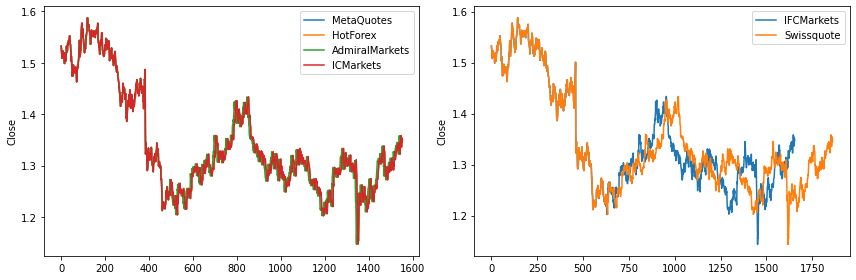

In [4]:
_, axs = plt.subplots(figsize=(12,4), ncols=2)
sns.lineplot(data=brokers['MetaQuotes'], x=brokers['MetaQuotes'].index, y='Close', label='MetaQuotes', ax=axs[0])
sns.lineplot(data=brokers['HotForex'], x=brokers['HotForex'].index, y='Close', label='HotForex', ax=axs[0])
sns.lineplot(data=brokers['AdmiralMarkets'], x=brokers['AdmiralMarkets'].index, y='Close', label='AdmiralMarkets', ax=axs[0])
sns.lineplot(data=brokers['ICMarkets'], x=brokers['ICMarkets'].index, y='Close', label='ICMarkets', ax=axs[0])
sns.lineplot(data=brokers['IFCMarkets'], x=brokers['IFCMarkets'].index, y='Close', label='IFCMarkets', ax=axs[1])
sns.lineplot(data=brokers['Swissquote'], x=brokers['Swissquote'].index, y='Close', label='Swissquote', ax=axs[1])
plt.tight_layout()
plt.show()

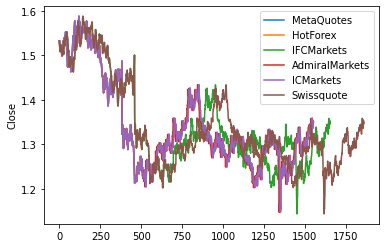

In [5]:
for k, v in brokers.items():
  sns.lineplot(data=v, x=v.index, y='Close', label=k)
plt.show()

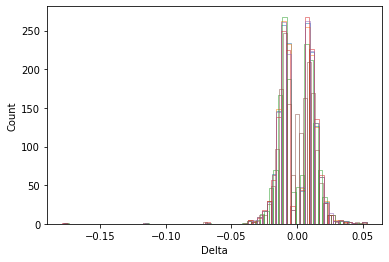

In [6]:
for k, v in brokers.items():
  sns.histplot(v['Delta'], fill=False, label=k)
plt.show()

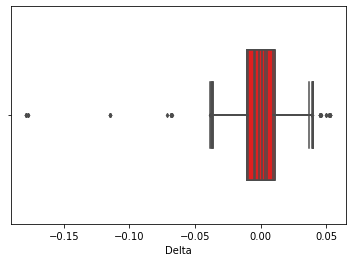

In [7]:
for m in brokers.values():
  sns.boxplot(data=m, x='Delta', color='red', fliersize=3, width=0.6)
plt.show()

In [8]:
def get_markets_by_prices(group, price_type='Close'):
  prices = {}
  for g in group:
    prices[g] = brokers[g][price_type]

  return pd.DataFrame(data=prices, columns=group)

group_1 = get_markets_by_prices(['MetaQuotes', 'HotForex', 'AdmiralMarkets', 'ICMarkets'])
group_1.head()

,MetaQuotes,HotForex,AdmiralMarkets,ICMarkets
0,1.53244,1.53244,1.53266,1.53244
1,1.52483,1.52483,1.52501,1.52483
2,1.51485,1.51485,1.51496,1.51485
3,1.51084,1.51084,1.51114,1.51084
4,1.50882,1.50882,1.50894,1.50882


In [9]:
group_1.corr()

,MetaQuotes,HotForex,AdmiralMarkets,ICMarkets
MetaQuotes,1.000000,0.999997,0.985668,0.999991
HotForex,0.999997,1.000000,0.985682,0.999992
AdmiralMarkets,0.985668,0.985682,1.000000,0.985657
ICMarkets,0.999991,0.999992,0.985657,1.000000


In [10]:
group_2 = get_markets_by_prices(['IFCMarkets', 'Swissquote'])
group_2.corr()

,IFCMarkets,Swissquote
IFCMarkets,1.000000,0.930862
Swissquote,0.930862,1.000000


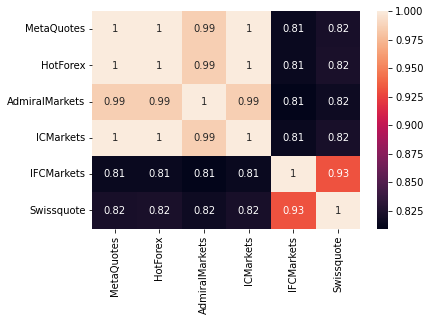

In [11]:
sns.heatmap(data=get_markets_by_prices(['MetaQuotes', 'HotForex', 'AdmiralMarkets', 'ICMarkets', 'IFCMarkets', 'Swissquote']).corr(), annot=True)
plt.show()

In [12]:
error = brokers['MetaQuotes']['Close'] - brokers['HotForex']['Close']
error= error**2
np.sqrt(error.mean())

0.00024436756815401873

In [13]:
from itertools import product

def rmse_matrix(brokers, brokers_labels, price_type):
  brokers_pairs = [item for item in product(brokers_labels, repeat=2)]
  rmse_ = []
  pairs_left = []
  pairs_right= []
  for p in brokers_pairs:
    error = brokers[p[0]][price_type] - brokers[p[1]][price_type]
    error= error**2
    rmse_.append(np.sqrt(error.mean()))
    pairs_left.append(p[0])
    pairs_right.append(p[1])
  return pd.DataFrame(data={'1':pairs_left, '2':pairs_right, 'RMSE':rmse_})

df_error_matrix = rmse_matrix(brokers, ['MetaQuotes', 'HotForex', 'AdmiralMarkets', 'ICMarkets', 'IFCMarkets', 'Swissquote'], 'Close')
df_error_matrix.head()

,1,2,RMSE
0,MetaQuotes,MetaQuotes,0.000000
1,MetaQuotes,HotForex,0.000244
2,MetaQuotes,AdmiralMarkets,0.016953
3,MetaQuotes,ICMarkets,0.000436
4,MetaQuotes,IFCMarkets,0.063614


In [14]:
error_matrix = df_error_matrix.pivot(index='1', columns='2', values='RMSE')
error_matrix 

2,AdmiralMarkets,HotForex,ICMarkets,IFCMarkets,MetaQuotes,Swissquote
1,,,,,,
AdmiralMarkets,0.000000,0.016948,0.016950,0.064431,0.016953,0.063043
HotForex,0.016948,0.000000,0.000426,0.063615,0.000244,0.062145
ICMarkets,0.016950,0.000426,0.000000,0.063612,0.000436,0.062137
IFCMarkets,0.064431,0.063615,0.063612,0.000000,0.063614,0.038359
MetaQuotes,0.016953,0.000244,0.000436,0.063614,0.000000,0.062143
Swissquote,0.063043,0.062145,0.062137,0.038359,0.062143,0.000000


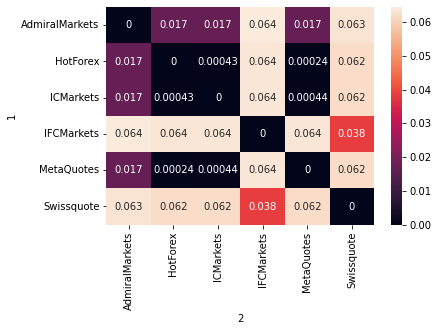

In [15]:
sns.heatmap(data=error_matrix, annot=True)
plt.show()

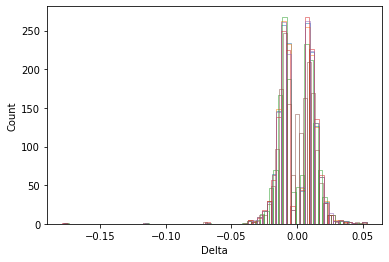

In [16]:
for k, v in brokers.items():
  sns.histplot(v['Delta'], fill=False, label=k)
plt.show()

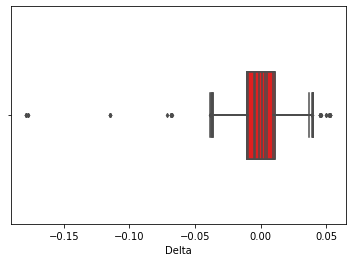

In [17]:
for b in brokers.values():
  sns.boxplot(data=b, x='Delta', color='red', fliersize=3, width=0.4)
plt.show()

In [18]:
def clear_outliers(brokers):
  for k, v in brokers.items():
    m= v['Delta']
    brokers[k]= brokers[k][(m>=-0.05) & (m<=0.04)]

clear_outliers(brokers)

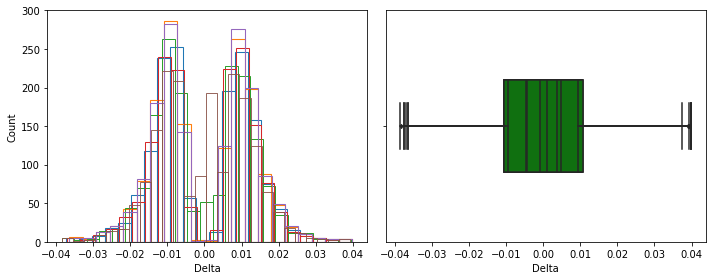

In [19]:
_, axs = plt.subplots(figsize=(10,4), ncols=2)

for k, v in brokers.items():
  sns.histplot(v['Delta'], fill=False, label=k, ax=axs[0])
for b in brokers.values():
  sns.boxplot(data=b, x='Delta', color='green', fliersize=3, width=0.4, ax=axs[1])

plt.tight_layout()
plt.show()

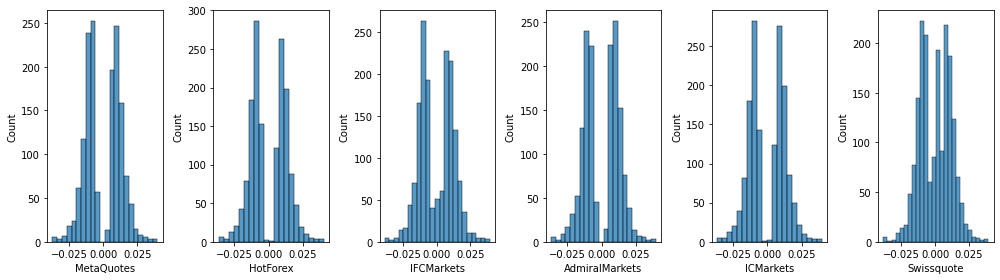

In [20]:
_, axs = plt.subplots(figsize=(14,4), ncols=len(brokers))

i = 0
for k, v in brokers.items():
  axs[i].set_xlabel(k)
  sns.histplot(v['Delta'], fill=True, label=k, ax=axs[i])
  i+= 1
  
plt.tight_layout()
plt.show()

In [21]:
normal_brokers = {}
ln_normal_brokers = {}

for k, v in brokers.items():
  normal_brokers[k] = v['Delta'].dropna()
for k, v in brokers.items():
  ln_normal_brokers[k] = np.log(v['Delta'].dropna())

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
from scipy.stats import shapiro

def test_normality(brokers, alpha=0.05):
  for k, m in brokers.items():
    stat, p = shapiro(m)
    print('Market:<{}> statistic={}, p-value={}'.format(k,np.round(stat,4), np.round(p,4)) )
    if p > alpha:
      print('Sample is Gaussian (fail to reject H0)')
    else:
      print('Sample does not look Gaussian (reject H0), H1 accepted')
    print('')

In [23]:
test_normality(normal_brokers)

Market:<MetaQuotes> statistic=0.9481, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<HotForex> statistic=0.9482, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<IFCMarkets> statistic=0.964, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<AdmiralMarkets> statistic=0.9475, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<ICMarkets> statistic=0.9484, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<Swissquote> statistic=0.9826, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted



In [24]:
test_normality(ln_normal_brokers)

Market:<MetaQuotes> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<HotForex> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<IFCMarkets> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<AdmiralMarkets> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<ICMarkets> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)

Market:<Swissquote> statistic=nan, p-value=1.0
Sample is Gaussian (fail to reject H0)



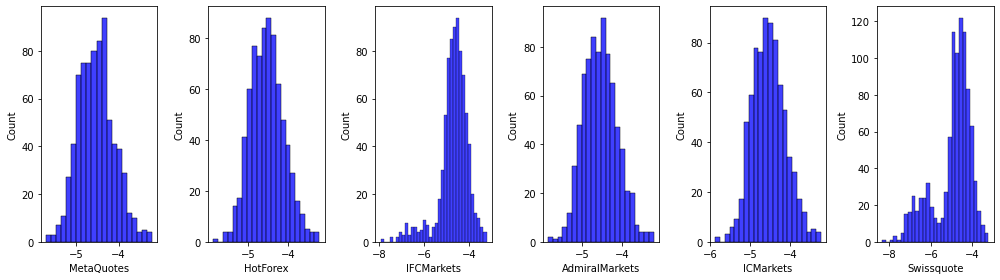

In [25]:
_, axs = plt.subplots(figsize=(14,4), ncols=len(ln_normal_brokers))

i = 0
for k, v in ln_normal_brokers.items():
  axs[i].set_xlabel(k)
  sns.histplot(v, ax=axs[i], color='blue')
  i+= 1
  
plt.tight_layout()
plt.show()

In [26]:
from scipy.stats import levene

stat, p = levene(ln_normal_brokers['MetaQuotes'].dropna(),
                 ln_normal_brokers['HotForex'].dropna(),
                 ln_normal_brokers['IFCMarkets'].dropna(),
                 ln_normal_brokers['AdmiralMarkets'].dropna(),
                 ln_normal_brokers['ICMarkets'].dropna(),
                 ln_normal_brokers['Swissquote'].dropna())
alpha = 0.05
if p > alpha:
	print('Samples have equal variances (fail to reject H0).')
else:
	print('Samples have [NOT] equal variances (reject H0), H1 accepted.')
print("statistic:{}, p-value:{}".format(stat, p))

Samples have [NOT] equal variances (reject H0), H1 accepted.
statistic:96.55299524704999, p-value:2.7472530217783185e-97


In [27]:
from scipy.stats import bartlett

stat, p = bartlett(ln_normal_brokers['MetaQuotes'].dropna(),
                   ln_normal_brokers['HotForex'].dropna(),
                   ln_normal_brokers['IFCMarkets'].dropna(),
                   ln_normal_brokers['AdmiralMarkets'].dropna(),
                   ln_normal_brokers['ICMarkets'].dropna(),
                   ln_normal_brokers['Swissquote'].dropna())
alpha = 0.05
if p > alpha:
	print('Samples have equal variances (fail to reject H0).')
else:
	print('Samples have [NOT] equal variances (reject H0), H1 accepted.')
print("statistic:{}, p-value:{}".format(stat, p))

Samples have [NOT] equal variances (reject H0), H1 accepted.
statistic:1140.5951040140442, p-value:2.1606178716945342e-244


In [28]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(ln_normal_brokers['MetaQuotes'].dropna(),
                                ln_normal_brokers['HotForex'].dropna(),
                                ln_normal_brokers['IFCMarkets'].dropna(),
                                ln_normal_brokers['AdmiralMarkets'].dropna(),
                                ln_normal_brokers['ICMarkets'].dropna(),
                                ln_normal_brokers['Swissquote'].dropna())
alpha = 0.05
if p > alpha:
	print('Samples have equal means(fail to reject H0).')
else:
	print('Samples have [NOT] equal means(reject H0), H1 accepted.')
print("statistic:{}, p-value:{}".format(stat, p))

Samples have [NOT] equal means(reject H0), H1 accepted.
statistic:1140.5951040140442, p-value:2.1606178716945342e-244


In [29]:
alpha = 0.05
stat, p = bartlett(ln_normal_brokers['MetaQuotes'].dropna(),
                   ln_normal_brokers['HotForex'].dropna(),
                   ln_normal_brokers['AdmiralMarkets'].dropna(),
                   ln_normal_brokers['ICMarkets'].dropna())
if p > alpha: print('Samples have equal variances (fail to reject H0).')
else: print('Samples have [NOT] equal variances (reject H0), H1 accepted.')
print("p-value:{}".format(p))

fvalue, pvalue = stats.f_oneway(ln_normal_brokers['MetaQuotes'].dropna(),
                                ln_normal_brokers['HotForex'].dropna(),
                                ln_normal_brokers['AdmiralMarkets'].dropna(),
                                ln_normal_brokers['ICMarkets'].dropna())
if p > alpha: print('Means are equal(fail to reject H0), perhaps the data comes from the same liquidity providers.')
else: print('Mean are [NOT] equal, H1 accepted(reject H0). Perhaps the data not comes from the same liquidity providers.')
print("p-value:{}".format(p))

Samples have equal variances (fail to reject H0).
p-value:0.9935373091045707
Means are equal(fail to reject H0), perhaps the data comes from the same liquidity providers.
p-value:0.9935373091045707


In [30]:
brokers['IFCMarkets'].head()

,Date,Delta,Type,Close
0,2015.01.02 00:00,-0.02225,bearish,1.53244
1,2015.01.04 00:00,-0.01303,bearish,1.52684
2,2015.01.05 00:00,-0.01160,bearish,1.52510
3,2015.01.06 00:00,-0.01650,bearish,1.51380
4,2015.01.07 00:00,-0.01003,bearish,1.51049


In [31]:
from datetime import datetime

def sync_prices_by_date(dict_dfs:dict, df_ref_name:str, df_to_compare_names:list, date_column_name:str='Date', price_type:str='Close', df_ref_time_format:str='%Y.%m.%d', dfs_time_format:str='%Y.%m.%d')->dict:
  def compare_prices_by_date(dict_dfs:dict, df_ref_name:str, df_to_compare_name:list, date_column_name='Date', price_type='Close', df_ref_time_format='%Y.%m.%d', dfs_time_format='%Y.%m.%d'):
    df_ref = dict_dfs[df_ref_name]
    df_comp= dict_dfs[df_to_compare_name]
    l1 = len(df_ref[date_column_name])
    l2 = len(df_comp[date_column_name])
    b1 = []
    b2 = []

    for i in range(l1):
      if i not in df_ref.index:
        continue
      
      d1 = df_ref[date_column_name][i]
      dmy1 = d1[:d1.index(' ')]
      for j in range(l2):
        if j not in df_comp.index:
          continue
        d2 = df_comp[date_column_name][j]
        dmy2 = d2[:d2.index(' ')]

        if datetime.strptime(dmy1, df_ref_time_format).date() == datetime.strptime(dmy2, dfs_time_format).date():
          b1.append(df_ref[price_type][i])
          b2.append(df_comp[price_type][j])
          break
    
    return pd.DataFrame(data={df_ref_name:b1, df_to_compare_name:b2})

  dicts_df = {}
  for n in df_to_compare_names:
    dicts_df[df_ref_name+'-'+n] = compare_prices_by_date(dict_dfs, df_ref_name, n, date_column_name, price_type, df_ref_time_format, dfs_time_format)
  
  return dicts_df

In [32]:
df = sync_prices_by_date(brokers, 'MetaQuotes', ['HotForex', 'IFCMarkets', 'AdmiralMarkets', 'ICMarkets', 'Swissquote'])

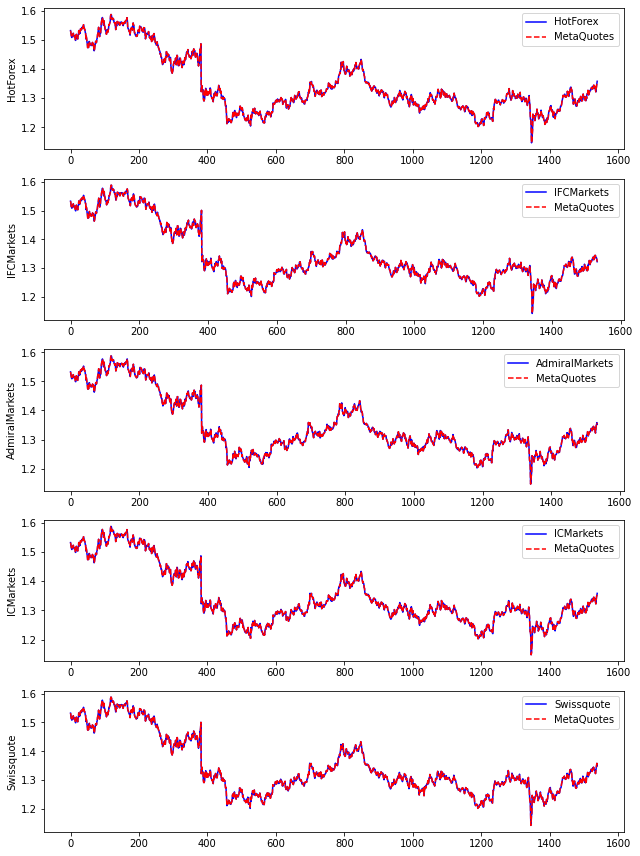

In [33]:
_, axs = plt.subplots(figsize=(9,12), nrows=len(df))
i = 0
m = ['HotForex', 'IFCMarkets', 'AdmiralMarkets', 'ICMarkets', 'Swissquote']
for k, v in df.items():
  sns.lineplot(data=v, x=v.index, y=m[i], label=m[i], ax=axs[i], color='blue')
  sns.lineplot(data=v, x=v.index, y=m[i], label='MetaQuotes', ax=axs[i], linestyle="dashed", color='red')
  i+= 1
plt.tight_layout()
plt.show()

In [34]:
for v in df.values():
  print(v.corr())
  print("")

            MetaQuotes  HotForex
MetaQuotes    1.000000  0.999997
HotForex      0.999997  1.000000

            MetaQuotes  IFCMarkets
MetaQuotes    1.000000    0.999924
IFCMarkets    0.999924    1.000000

                MetaQuotes  AdmiralMarkets
MetaQuotes        1.000000        0.999991
AdmiralMarkets    0.999991        1.000000

            MetaQuotes  ICMarkets
MetaQuotes    1.000000   0.999993
ICMarkets     0.999993   1.000000

            MetaQuotes  Swissquote
MetaQuotes     1.00000     0.99993
Swissquote     0.99993     1.00000



In [35]:
from itertools import product

def rmse_matrix(df_brokers):
  brokers_pairs = [item for item in product(df_brokers.columns, repeat=2)]
  rmse_ = []
  pairs_left = []
  pairs_right= []
  for p in brokers_pairs:
    error = df_brokers[p[0]] - df_brokers[p[1]]
    error= error**2
    rmse_.append(np.sqrt(error.mean()))
    pairs_left.append(p[0])
    pairs_right.append(p[1])
  df_error_matrix = pd.DataFrame(data={'index':pairs_left, 'column':pairs_right, 'RMSE':rmse_})
  return df_error_matrix.pivot(index='index', columns='column', values='RMSE')

err_matrix = []
for v in df.values():
  print(rmse_matrix(v))
  err_matrix.append(rmse_matrix(v))
  print("")

column      HotForex  MetaQuotes
index                           
HotForex    0.000000    0.000227
MetaQuotes  0.000227    0.000000

column      IFCMarkets  MetaQuotes
index                             
IFCMarkets    0.000000    0.001236
MetaQuotes    0.001236    0.000000

column          AdmiralMarkets  MetaQuotes
index                                     
AdmiralMarkets        0.000000    0.000449
MetaQuotes            0.000449    0.000000

column      ICMarkets  MetaQuotes
index                            
ICMarkets    0.000000    0.000382
MetaQuotes   0.000382    0.000000

column      MetaQuotes  Swissquote
index                             
MetaQuotes    0.000000    0.001185
Swissquote    0.001185    0.000000



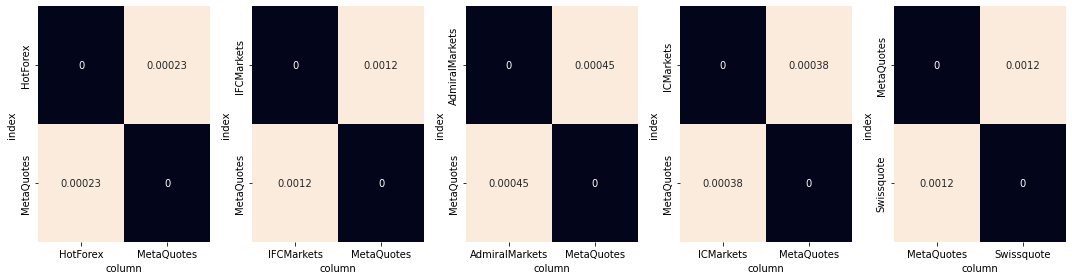

In [36]:
l = len(err_matrix)
_, axs = plt.subplots(figsize=(15,4), ncols=l)
for i in range(l):
  sns.heatmap(err_matrix[i], annot=True, cbar=False, ax=axs[i])
plt.tight_layout()
plt.show()

In [37]:
df_dukascopy = pd.read_csv('https://raw.githubusercontent.com/benvictoria17/Finance/master/dataset/brokers_markets/DUKASCOPY_GBPUSD_Candlestick_1_D_BID_01.01.2015-31.12.2020.csv')
df_dukascopy.head()

,Local time,Open,High,Low,Close,Volume
0,01.01.2015 19:00:00.000 GMT-0300,1.55783,1.55871,1.53252,1.53252,214767.0782
1,02.01.2015 19:00:00.000 GMT-0300,1.53252,1.53252,1.53252,1.53252,0.0000
2,03.01.2015 19:00:00.000 GMT-0300,1.53252,1.53252,1.53252,1.53252,0.0000
3,04.01.2015 19:00:00.000 GMT-0300,1.53002,1.53193,1.51535,1.52472,210874.6717
4,05.01.2015 19:00:00.000 GMT-0300,1.52474,1.52739,1.51408,1.51502,215543.1504


In [38]:
df_dukascopy.rename({'Local time':'Date'}, inplace=True, axis=1)

In [39]:
brokers['Dukascopy'] = df_dukascopy

In [40]:
brokers_labels = ['MetaQuotes', 'HotForex', 'IFCMarkets', 'AdmiralMarkets', 'ICMarkets', 'Swissquote']
df_markets = sync_prices_by_date(brokers, 'Dukascopy', brokers_labels, date_column_name='Date', price_type='Close', df_ref_time_format='%d.%m.%Y', dfs_time_format='%Y.%m.%d')

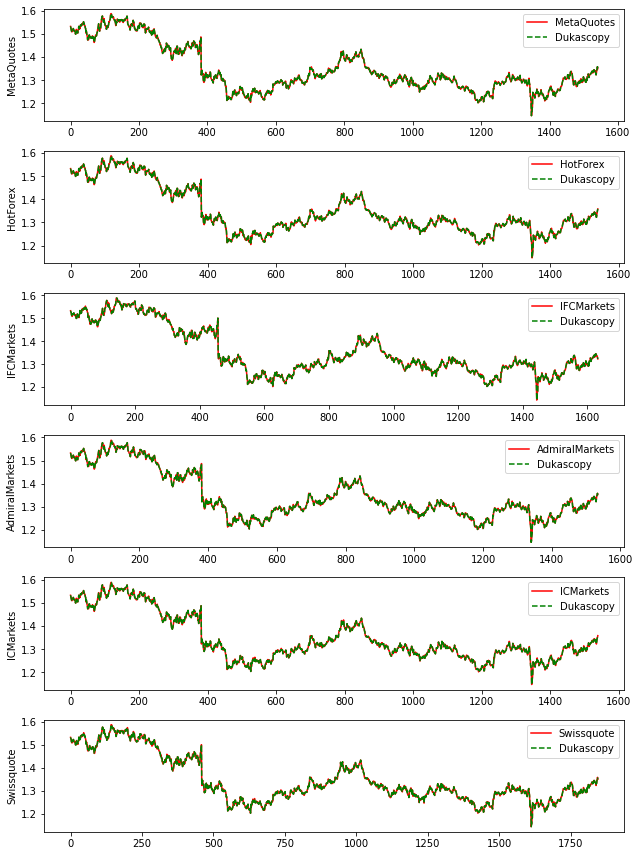

In [41]:
_, axs = plt.subplots(figsize=(9,12), nrows=len(df_markets))
i = 0
m = ['MetaQuotes', 'HotForex', 'IFCMarkets', 'AdmiralMarkets', 'ICMarkets', 'Swissquote']
for k, v in df_markets.items():
  sns.lineplot(data=v, x=v.index, y=m[i], label=m[i], ax=axs[i], color='red')
  sns.lineplot(data=v, x=v.index, y=m[i], label='Dukascopy', ax=axs[i], linestyle="dashed", color='green')
  i+= 1
plt.tight_layout()
plt.show()

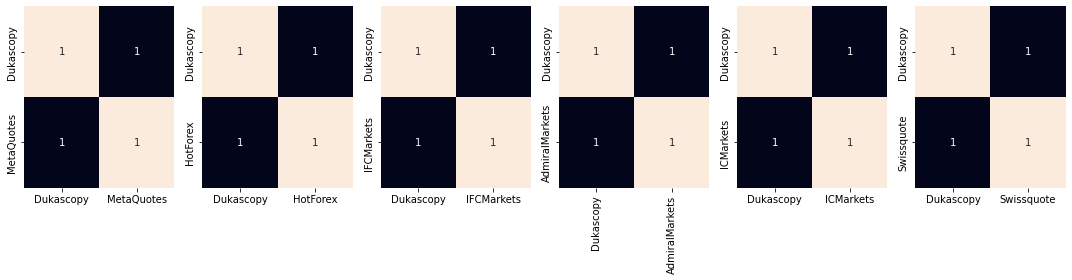

In [42]:
_, axs = plt.subplots(figsize=(15,4), ncols=len(df_markets))
i = 0
for v in df_markets.values():
  sns.heatmap(v.corr(), annot=True, cbar=False, ax=axs[i])
  i+= 1
plt.tight_layout()
plt.show()

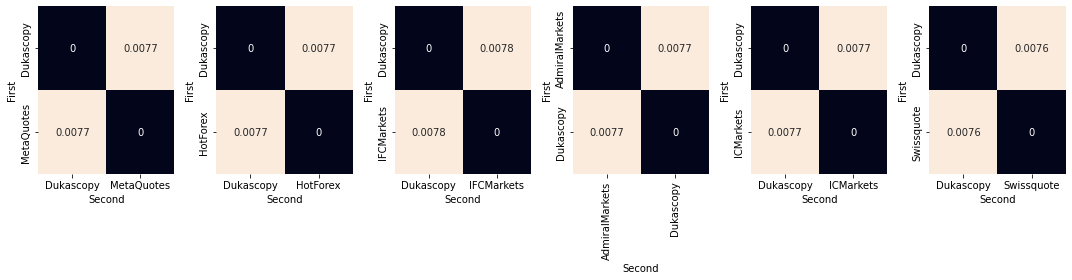

In [43]:
from itertools import product

def rmse_matrix(df_brokers):
  brokers_pairs = [item for item in product(df_brokers.columns, repeat=2)]
  rmse_ = []
  pairs_left = []
  pairs_right= []
  for p in brokers_pairs:
    error = df_brokers[p[0]] - df_brokers[p[1]]
    error= error**2
    rmse_.append(np.sqrt(error.mean()))
    pairs_left.append(p[0])
    pairs_right.append(p[1])
  df_error_matrix = pd.DataFrame(data={'First':pairs_left, 'Second':pairs_right, 'RMSE':rmse_})
  return df_error_matrix.pivot(index='First', columns='Second', values='RMSE')

_, axs = plt.subplots(figsize=(15,4), ncols=len(df_markets))
i = 0
for v in df_markets.values():
  sns.heatmap(rmse_matrix(v), annot=True, cbar=False, ax=axs[i])
  i+= 1
plt.tight_layout()
plt.show()

In [44]:
def random_walk(size, prob_move_up=0.5, volatility=1, start=1):
  p = prob_move_up
  q = 1 - p
  prob = [q, p]

  positions = [None for _ in range(size)]
  noise     = [None for _ in range(size)]
  positions[0] = noise[0] = start

  for i in range(1, size):
    r = np.random.random(1)[0]
    step = np.abs(np.random.normal(0, volatility, 1)[0])
    if r < prob[1]:
      dir= +step
    else:
      dir= -step

    positions[i]= positions[i-1] + dir
    noise[i] = step
  return positions, noise

In [45]:
np.random.seed(6)
size = df_dukascopy.shape[0]
index = np.arange(size)
rw_price, rw_noise = random_walk(size, prob_move_up=0.55, volatility=0.001, start=1.5)

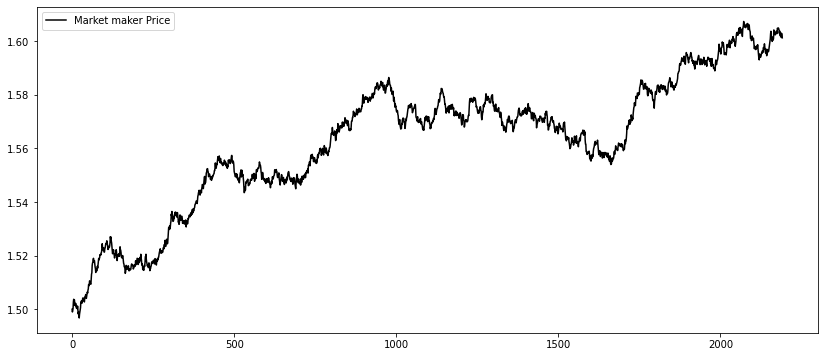

In [46]:
plt.subplots(figsize=(14, 6))
sns.lineplot(x=index, y=rw_price, label='Market maker Price', color='black')
plt.show()

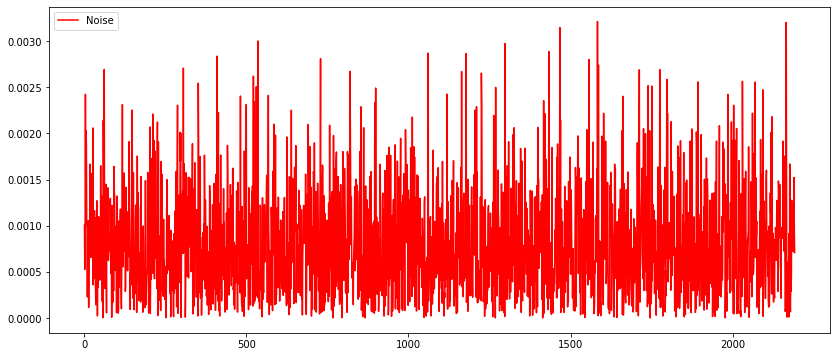

In [47]:
plt.subplots(figsize=(14, 6))
sns.lineplot(x=index[1:], y=rw_noise[1:], label='Noise', color='r')
plt.show()

In [48]:
df_brokers = pd.DataFrame()
df_brokers['MarketMaker'] = rw_price
df_brokers['Dukascopy'] = df_dukascopy['Close']

In [49]:
df_brokers.corr()

,MarketMaker,Dukascopy
MarketMaker,1.00000,-0.72213
Dukascopy,-0.72213,1.00000


In [50]:
from itertools import product

def rmse_matrix(df_brokers):
  brokers_pairs = [item for item in product(df_brokers.columns, repeat=2)]
  rmse_ = []
  pairs_left = []
  pairs_right= []
  for p in brokers_pairs:
    error = df_brokers[p[0]] - df_brokers[p[1]]
    error= error**2
    rmse_.append(np.sqrt(error.mean()))
    pairs_left.append(p[0])
    pairs_right.append(p[1])
  df_error_matrix = pd.DataFrame(data={'First':pairs_left, 'Second':pairs_right, 'RMSE':rmse_})
  return df_error_matrix.pivot(index='First', columns='Second', values='RMSE')

rmse_matrix(df_brokers)

Second,Dukascopy,MarketMaker
First,,
Dukascopy,0.000000,0.248568
MarketMaker,0.248568,0.000000


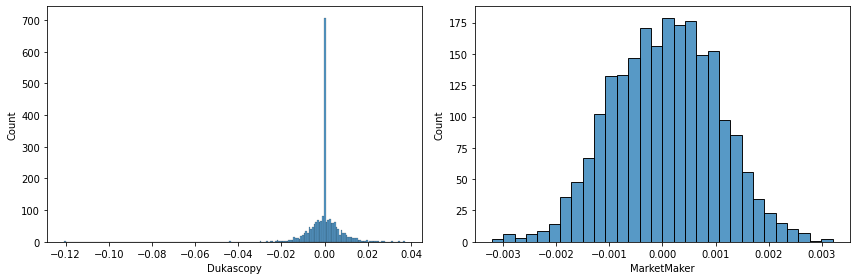

In [51]:
_, axs = plt.subplots(figsize=(12, 4), ncols=2)
sns.histplot(df_brokers['Dukascopy'].diff(), ax=axs[0])
sns.histplot(df_brokers['MarketMaker'].diff(), ax=axs[1])
plt.tight_layout()
plt.show()

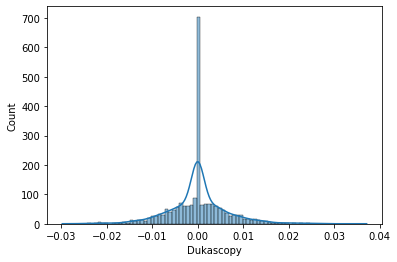

In [52]:
dukascopy_diff = df_brokers['Dukascopy'].diff()
marketmaker_diff = df_brokers['MarketMaker'].diff()

dukascopy_diff = dukascopy_diff[(dukascopy_diff > -0.04) & (dukascopy_diff < 0.04)]
sns.histplot(dukascopy_diff, kde=True)
plt.show()

In [53]:
from scipy.stats import shapiro
from scipy.stats import bartlett
import scipy.stats as stats

def is_normal(brokers, alpha=0.05):
  err_lvl = 0
  for k, m in brokers.items():
    stat, p = shapiro(m)
    print('Market:<{}> statistic={}, p-value={}'.format(k,np.round(stat,4), np.round(p,4)) )
    if p > alpha:
      print('Sample is Gaussian (fail to reject H0)')
      err_lvl+= 1
    else:
      print('Sample does not look Gaussian (reject H0), H1 accepted')
    print('')
  return err_lvl == len(brokers)

def equal_pair_variances(broker_1, broker_2, alpha = 0.05):
  stat, p = bartlett(broker_1, broker_2)
  is_equal = False
  if p > alpha:
    print('Samples have equal variances (fail to reject H0).')
    is_equal = True
  else:
    print('Samples have [NOT] equal variances (reject H0), H1 accepted.')
  print("statistic:{}, p-value:{}".format(stat, p))
  print('')
  return is_equal

def t_test(broker_1, broker_2, equal_var=True, alpha = 0.05):
  fvalue, p = stats.ttest_ind(broker_1, broker_2, equal_var=equal_var)
  is_equal = False
  if p > alpha:
    print('Samples have equal means(fail to reject H0).')
    is_equal = True
  else:
    print('Samples have [NOT] equal means(reject H0), H1 accepted.')
  print("statistic:{}, p-value:{}".format(fvalue, p))
  return is_equal

In [54]:
def test_brokers(name1,broker1, name2,broker2):
  broker1 = broker1.dropna()
  broker2 = broker2.dropna()
  normality = is_normal({name1:broker1, name2:broker2})
  if normality == False or normality == True:
    equal_var = equal_pair_variances(broker1, broker2)
    return t_test(broker1, broker2, equal_var=equal_var)

print("[output]:",test_brokers('Dukascopy',dukascopy_diff, 'MarketMaker',marketmaker_diff) )

Market:<Dukascopy> statistic=0.929, p-value=0.0
Sample does not look Gaussian (reject H0), H1 accepted

Market:<MarketMaker> statistic=0.9986, p-value=0.0686
Sample is Gaussian (fail to reject H0)

Samples have [NOT] equal variances (reject H0), H1 accepted.
statistic:5300.5874730672085, p-value:0.0

Samples have equal means(fail to reject H0).
statistic:-0.1919301204371403, p-value:0.8478139712892554
[output]: True
